# **Despliege del modelo con FastAPI**
---


In [ ]:
!pip install fastapi

Importamos las librerías necesarias:

In [ ]:
import pandas as pd
from IPython.display import display

# **PARTE I: Carga de Textos**
---

In [ ]:
import re
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from IPython.display import display
plt.style.use("ggplot")
spacy.cli.download("es_core_news_sm")

In [ ]:
# ML models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# scikit-learn:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import pickle
from sklearn.metrics import roc_auc_score

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arseniitretiakov/noticias-falsas-en-espaol")

print("Path to dataset files:", path)

In [ ]:
import pandas as pd

# Assuming the dataset is in a CSV file named "fakes1000.csv"
file_path = path + "/fakes1000.csv"
df = pd.read_csv(file_path)

print(df.head()) # Print the first few rows of the DataFrame

In [ ]:
df.astype({'class': 'category'}).dtypes

# **PARTE II: Preprocesamiento**
---

In [ ]:
df['class'] = df['class'].replace({True: 1, False: 0})

In [ ]:
!pip install spacy==3.5.3
!python -m spacy download es_core_news_sm

import spacy

# Carga el modelo en español de spaCy
nlp = spacy.load("es_core_news_sm")

In [ ]:
def preprocess_text(text):

  doc = nlp(text)

  # Tokenización, eliminación de stopwords, lematización y minúsculas
  lemmas = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]

  # Unión de lemas en una cadena de texto
  preprocessed_text = " ".join(lemmas)

  return preprocessed_text

In [ ]:
# Aplica la función de preprocesamiento a la columna 'Text' de tu DataFrame
df['preprocessed_text'] = df['Text'].apply(preprocess_text)

# **PARTE III: Extracción de Características**
---

#### *División del conjunto de datos (Prueba - Entrenamiento)*

In [ ]:
X=df['preprocessed_text']
y=df['class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)

#### *Método de Vectorización 1: Bolsa de Palabras*

In [ ]:
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)

# **PARTE IV: Modelamiento**

## **2. Modelamiento y Evaluación**
---

Vamos a entrenar un modelo para clasificar automáticamente discursos de odio a partir de textos. Comenzamos dividiendo el conjunto de datos en las particiones de entrenamiento y prueba:

#### *Modelo 1: Random Forest + Countvectorizer*

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
# Creación del modelo con los mejores hiperparámetros
best_model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300, random_state=42)

# Entrenamiento
best_model.fit(X_train_dtm, y_train)

# Predicción
y_pred = best_model.predict(X_test_dtm)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Countvectorizer: %.2f%%" % (accuracy * 100.0))

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

In [ ]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

In [ ]:
# Dataframe con las métricas en porcentaje
metrics_df = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC'],
    'Valor': [accuracy, precision, recall, f1, roc_auc]
})
metrics_df['Valor (%)'] = (metrics_df['Valor'] * 100).round(2)


# Crear de imagen resumen con méticas

fig, ax = plt.subplots(figsize=(8, 4))  # Ajusta el tamaño si es necesario

sns.heatmap(
    metrics_df[['Métrica', 'Valor (%)']].set_index('Métrica').T,
    annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=ax
)

ax.set_title('Métricas de Evaluación del Modelo', fontsize=14)
plt.tight_layout()

# Guarda la tabla como una imagen
plt.savefig('metricas_modelo.png')

In [ ]:
# Predicciones del modelo en el conjunto de prueba
y_pred = best_model.predict(X_test_dtm)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Imagen matriz de confusión
plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura si es necesario
ax = plt.subplot()

sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')

ax.set_xlabel('Predicciones')
ax.set_ylabel('Valores Reales')
ax.set_title('Matriz de Confusión')

ax.xaxis.set_ticklabels(['Verdadero', 'Falso'])
ax.yaxis.set_ticklabels(['Verdadero', 'Falso'])

# Guardar la figura como una imagen PNG
plt.savefig('matriz_confusion.png')

# Mostrar la matriz de confusión
plt.show()

Utilizaremos la herramienta `joblib` para guardar el modelo:

In [ ]:
import joblib

Guardamos el modelo:

In [ ]:
joblib.dump(best_model, "model.joblib")

In [ ]:
joblib.dump(vect, "vectorizer.joblib")

In [ ]:
!pip install --upgrade --force-reinstall pydantic
from pydantic import BaseModel
from typing import List

class ApiInput(BaseModel):
    text: List[str]

Ahora, definimos una clase para la salida del API:

In [ ]:
%%writefile main.py


from fastapi import FastAPI # importamos el API
from pydantic import BaseModel
from typing import List
import os
import joblib # importamos la librería para cargar el modelo

class ApiInput(BaseModel):
    texts: List[str]

class ApiOutput(BaseModel):
    is_fake: List[int]

app = FastAPI() # creamos el api
model = joblib.load("model.joblib") # cargamos el modelo.
vectorizer = joblib.load("vectorizer.joblib")


@app.post("/fake") # creamos api que permita requests de tipo post.
async def define_sentiment(data: ApiInput) -> ApiOutput:
    # Convertir los textos en vectores
    text_vectors = vectorizer.transform(data.texts)
    predictions = model.predict(text_vectors).flatten().tolist() # generamos la predicción
    preds = ApiOutput(is_fake=predictions) # estructuramos la salida del API.
    return preds # retornamos los resultados

# Configuramos el puerto para Railway
if __name__ == "__main__":
    port = int(os.getenv("PORT", 8080))
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=port)

In [ ]:
!apt install tree

In [ ]:
!git --version

In [ ]:
import os
from IPython import get_ipython

In [ ]:
!pip install dvc dvc-gdrive

In [ ]:
!mkdir 'proyecto'

In [ ]:
%cd 'proyecto'

In [ ]:
!git init

Inicializamos el repositorio:

In [ ]:
!git config --global user.email ""
!git config --global user.name "Claudia Lorena Cañon Diaz"
!git config --global init.defaultBranch master

token github

In [ ]:
token = "" # Agregue su token dentro de las comillas.

Repositorio github

In [ ]:
repo_url = "https://github.com/HICWhiteFox/tdsp_E16" # Agruegue la url de su repositorio dentro de las comillas.

Ahora, usaremos una expresión regular para reemplazar el token en esta url:

In [ ]:
import re
pat = re.compile(r"(https://)(.*)")

Formatear URL

In [ ]:
match = re.match(pat, repo_url)
url_token = "".join([match.group(1), token, "@", match.group(2)])
os.environ["GITHUB"] = url_token

Clonar repositorio

In [ ]:
!git clone $GITHUB

Adicionalmente, debemos crear el archivo `requirements.txt` con las dependencias del proyecto:

In [ ]:
%%writefile requirements.txt
scikit-learn
fastapi
uvicorn
joblib

In [ ]:
!pwd

In [ ]:
%cd 'tdsp_E16/docs/deployment'

Adicional a esto, Railway requiere la creación de un archivo de configuración:

In [ ]:
%%writefile railway.json
{
  "$schema": "https://railway.app/railway.schema.json",
  "build": {
    "builder": "NIXPACKS"
  },
  "deploy": {
    "startCommand": "uvicorn main:app --host 0.0.0.0 --port $PORT",
    "restartPolicyType": "ON_FAILURE",
    "restartPolicyMaxRetries": 10
  }
}

Ahora agregamos los archivos al area de preparación:

In [ ]:
!git add railway.json requirements.txt main.py model.joblib
!git commit -m "Agregamos los archivos para el uso de fastAPI como despliegue"

In [ ]:
!git add ../../src/requirements.txt
!git commit -m "ajuste archivos en src del proyecto"

In [ ]:
!git status

Finalmente, enlazamos el repositorio local con el nuevo repositorio en Github con el comando `git remote`:

In [ ]:
!git remote add origin $GITHUB

En este punto, las versiones local (Colab) y remoto (Github) son distintas, para subir los cambios podemos usar el comando `git push` especificando la rama que deseamos actualizar:

In [ ]:
!git push origin master

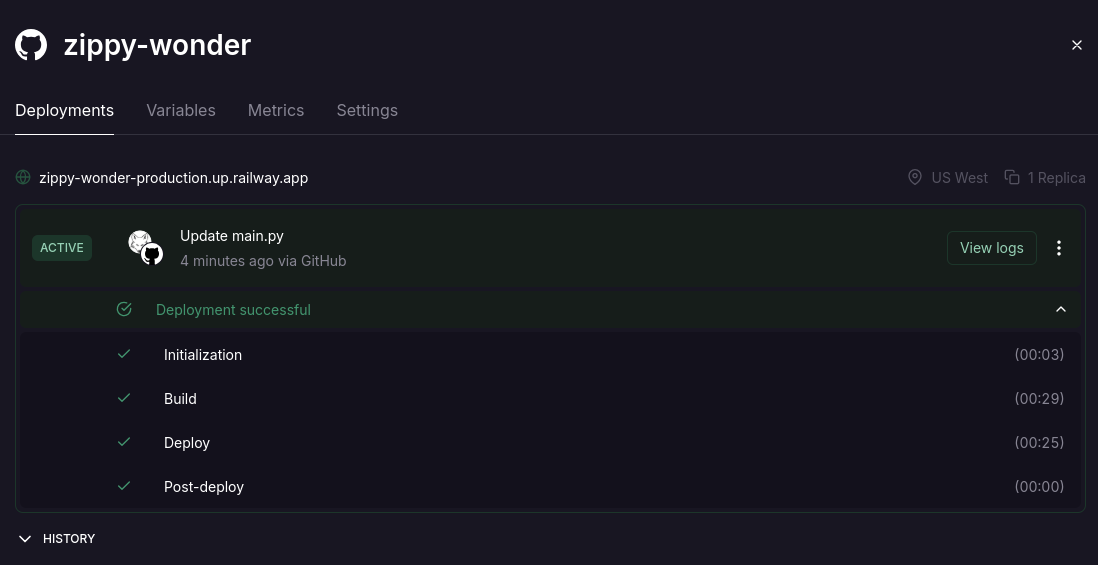

In [ ]:
model_url = "https://zippy-wonder-production.up.railway.app" #url de railway

Ahora podemos validar que el API funcione correctamente, vamos a consumirlo con la librería `requests`:

In [ ]:
import requests

Veamos el resultado para un texto de una noticia:

In [ ]:
r = requests.post(os.path.join(model_url, "fake"), json={"texts": ["Retrasan el regreso de los astronautas que fueron a la Estación Espacial por 8 días y se van a quedar al menos 10 meses"]})
print(r.json())

In [ ]:
r = requests.post(os.path.join(model_url, "fake"), json={"texts": ["Gobierno Petro expide decreto de presupuesto para 2025: hace recorte y será por 511 billones de pesos"]})
print(r.json())